## ライブラリ/モジュール読み込み

In [1]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import seaborn as sns
import japanize_matplotlib
import matplotlib.pyplot as plt
import optuna

# モデル構築のためのライブラリ
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
)

# データの前処理のためのライブラリ
from ydata_profiling import ProfileReport

# pandasのカラムが100列まで見れるようにする
pd.set_option("display.max_columns", 100)

# 表示する行数の上限を解除
pd.set_option("display.max_rows", None)

# 表示制限を解除
np.set_printoptions(threshold=np.inf)

In [2]:
# 独自モジュール読みこみ
import sys

sys.path.append("/workspace/working")

from src.models import xgb_train_cv, lgb_train_cv, lasso_train_cv, ridge_train_cv
from src.optuna import optimize_xgb, optimize_lgb

## ハイパーパラメータ

In [5]:
# XGBoostの最初のパラメータ
params_xgb1 = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "metric": "rmse",
    "max_depth": 6,
    "n_estimators": 100000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 123,
    "enable_categorical": True,
    "early_stopping_rounds": 100,
    "importance_type": "total_gain",
    "verbosity": 0,  # ログを非表示
}

#  Optunaによるハイパーパラメータ
params_xgb2 = {
    # "eta": 0.05,
    "eta": 0.01,  # 提出時は学習率を下げる # ベストスコア
    "min_child_weight": 4.08670533675578,
    "max_depth": 3,
    "subsample": 0.7,
    "colsample_bytree": 0.85,
    "gamma": 2.727032514224038e-08,
    "objective": "reg:squarederror",
    "metric": "rmse",
    "alpha": 0.0,
    "lambda": 1.0,
    "n_estimators": 10000,
    "importance_type": "total_gain",
    "early_stopping_rounds": 100,
    "random_state": 123,
}


# ------------ Optuna 用の基本パラメータ ----------
# 探索しないハイパーパラメータ
params_base_xgb = {
    "objective": "reg:squarederror",
    "metric": "rmse",
    "eta": 0.05,  # チューニング時は固定、提出時により小さくする
    # "gamma": 0.0,
    "alpha": 0.0,
    "lambda": 1.0,
    # "min_child_weight": 1,
    # "max_depth": 5,
    # "subsample": 0.8,
    # "colsample_bytree": 0.8,
    "n_estimators": 10000,  # 十分大きくし、アーリーストッピングで制御する
    "importance_type": "total_gain",
    "early_stopping_rounds": 100,
    "random_state": 123,
}

In [6]:
# LightGBMのパラメータ
params_lgb1 = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "n_estimators": 100000,
    "random_state": 123,
    "importance_type": "gain",
    "verbose": -1,  # 追加 # ログを非表示
}

# Optunaのハイパーパラメータ(SalePrice外れ値 2つを除外)
params_lgb2 = {
    "learning_rate": 0.05,
    "min_child_samples": 5,
    "max_depth": 8,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.6,
    "min_gain_to_split": 3.818618046561783e-07,
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    "bagging_freq": 1,
    "n_estimators": 10000,
    "importance_type": "gain",
    "random_state": 42,
}

# 探索しないハイパーパラメータ
params_base_lgb = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,  # チューニング時は固定、提出時により小さくする
    # "min_gain_to_split": 0.0,
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    # "min_child_samples": 20,
    # "max_depth": 5,
    # "bagging_fraction": 0.8,
    "bagging_freq": 1,  # subsampleを有効にするために必要
    # "feature_fraction": 0.8,
    "n_estimators": 10000,  # 十分大きくし、アーリーストッピングで制御する
    "importance_type": "gain",
    "random_state": 42,
}

## EDA・前処理

In [7]:
# データの読み込み
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [8]:
display(df_train[df_train["SalePrice"] > 700000])

df_train = df_train.drop(index=[691, 1182])  # 700000以上のデータを削除
# df_train = df_train.drop(index=[691, 898, 1169, 1182])  # 600000以上のデータを削除

print(len(df_train[df_train["SalePrice"] > 700000]))
df_train.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,NaN,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


0


(1458, 81)

In [9]:
### 後で使うカラムを取り出しておく

# 説明データの目的変数`SalePrice`のカラムを取り出しておく
y_train = df_train["SalePrice"]

# テストデータの'ID'のカラムを取り出しておく
id_test = df_test["Id"]

In [10]:
# trainデータとtestデータを結合する
df_all = pd.concat([df_train.drop(columns="SalePrice"), df_test])

In [11]:
# 欠損値の確認
# print(df_all.isnull().sum())

# 欠損値のあるカラムを抽出
missing_columns = df_all.columns[df_all.isnull().sum() > 0]
missing_columns = missing_columns.sort_values()
missing_columns

Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SaleType', 'TotalBsmtSF', 'Utilities'],
      dtype='object')

#### 欠損値処理

In [12]:
df_all["Alley"] = df_all["Alley"].fillna("None")

In [13]:
for col in ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]:
    df_all[col] = df_all[col].fillna("None")

In [14]:
cols = [
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "BsmtFullBath",
    "BsmtHalfBath",
]

for col in cols:
    df_all[col] = df_all[col].fillna(0)

In [15]:
df_all["Electrical"] = df_all["Electrical"].fillna(df_all["Electrical"].mode()[0])

In [16]:
for col in ["Exterior1st", "Exterior2nd"]:
    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])

In [17]:
df_all["Fence"] = df_all["Fence"].fillna("None")

In [18]:
df_all["FireplaceQu"] = df_all["FireplaceQu"].fillna("None")

In [19]:
df_all["Functional"] = df_all["Functional"].fillna(df_all["Functional"].mode()[0])

In [20]:
for col in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    df_all[col] = df_all[col].fillna("None")

In [21]:
for col in ["GarageArea", "GarageCars", "GarageYrBlt"]:
    df_all[col] = df_all[col].fillna(0)

In [22]:
df_all["KitchenQual"] = df_all["KitchenQual"].fillna(df_all["KitchenQual"].mode()[0])

In [23]:
df_all["LotFrontage"] = df_all["LotFrontage"].fillna(df_all["LotFrontage"].median())

In [24]:
df_all["MSZoning"] = df_all["MSZoning"].fillna(df_all["MSZoning"].mode()[0])

In [25]:
df_all["MasVnrArea"] = df_all["MasVnrArea"].fillna(df_all["MasVnrArea"].median())

In [26]:
df_all["MasVnrType"] = df_all["MasVnrType"].fillna("None")

In [27]:
df_all["MiscFeature"] = df_all["MiscFeature"].fillna("None")

In [28]:
df_all["PoolQC"] = df_all["PoolQC"].fillna("None")

In [29]:
df_all["SaleType"] = df_all["SaleType"].fillna(df_all["SaleType"].mode()[0])

In [30]:
df_all["Utilities"] = df_all["Utilities"].fillna(df_all["Utilities"].mode()[0])

In [31]:
df_all.isnull().sum().sum()

0

In [32]:
df_all_not_missing = df_all.copy()

#### 前処理（関数化）

In [33]:
# データの前処理をまとめた関数
def data_pre(df):
    # 欠損値処理

    ### 試し
    ###  欠損値が90％以上のカラムを除去
    # df = df.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"])

    # 文字列の変数の欠損は「'None'」、数字の変数の欠損は「0」で埋める
    # for colum in df.columns:
    #     # object型の場合
    #     if df[colum].dtype == "object":
    #         df[colum].fillna("None", inplace=True)
    #     # 数値型の場合
    #     else:
    #         df[colum].fillna(0, inplace=True)

    # 数値型のカテゴリ変数をObject型のカテゴリ変数に変換
    df["MSSubClass"] = df["MSSubClass"].astype("category")
    df["YrSold"] = df["YrSold"].astype("category")
    df["MoSold"] = df["MoSold"].astype("category")
    df["OverallCond"] = df["OverallCond"].astype(str)

    return df

In [34]:
# データの前処理を実行
df_all = data_pre(df_all_not_missing)

In [35]:
### 特徴量の追加

# TotalSF(総面積)を新たな特徴量として加える
df_all["TotalSF"] = df_all["TotalBsmtSF"] + df_all["1stFlrSF"] + df_all["2ndFlrSF"]

# ガレージの広さと駐車台数の相乗効果
df_all["GarageInteraction"] = df_all["GarageCars"] * df_all["GarageArea"]

In [36]:
# 特徴量の削除
cols_to_drop = ["TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]

df_all = df_all.drop(cols_to_drop, axis=1)

In [37]:
### 歪度を確認
import math

# 数値特徴量のリストを取得
numerical_columns = df_all.select_dtypes(include=["float64", "int64"]).columns
len(numerical_columns)

# # グリッドサイズを動的に計算
# num_columns = len(numerical_columns)
# num_rows = math.ceil(num_columns / 3)  # 1行あたり3列

# # ヒストグラムを描画
# plt.figure(figsize=(12, 5 * num_rows))  # 図のサイズを調整
# for i, column in enumerate(numerical_columns, 1):
#     plt.subplot(num_rows, 3, i)  # 動的に計算されたグリッドサイズを使用
#     sns.histplot(df_all[column], kde=True)
#     plt.title(f"Histogram of {column}")
# plt.tight_layout()
# plt.show()

32

In [38]:
# # 箱ひげ図を描画
# plt.figure(figsize=(12, 5 * num_rows))  # 図のサイズを調整
# for i, column in enumerate(numerical_columns, 1):
#     plt.subplot(num_rows, 3, i)  # 動的に計算されたグリッドサイズを使用
#     sns.boxplot(x=df_all[column])
#     plt.title(f"Boxplot of {column}")
# plt.tight_layout()
# plt.show()

In [39]:
# 統計量の確認
stats = df_all[numerical_columns].describe().transpose()

# 歪度（skewness）を計算
skewness = df_all[numerical_columns].skew()
# # 結果を表示
# print("統計量:")
# display(stats)
# print("\n歪度:")
# display(skewness)

# skewnessが大きいものを抽出
skewness_threshold = 1.5
skewness_columns = skewness[abs(skewness) > skewness_threshold].index
# 歪度が大きい特徴量を表示
print("歪度:")
display(df_all[skewness_columns].skew())
print("\n歪度が大きい特徴量:")
display(skewness_columns)

# display(df_all[skewness_columns].head())

歪度:


LotFrontage       1.670978
LotArea          12.842563
MasVnrArea        2.594383
BsmtFinSF2        4.146636
LowQualFinSF     12.090757
BsmtHalfBath      3.946524
KitchenAbvGr      4.302763
GarageYrBlt      -3.906629
WoodDeckSF        1.846866
OpenPorchSF       2.536288
EnclosedPorch     4.004404
3SsnPorch        11.377932
ScreenPorch       3.947131
PoolArea         17.791280
MiscVal          21.950962
dtype: float64


歪度が大きい特徴量:


Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', 'KitchenAbvGr', 'GarageYrBlt', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')

In [40]:
df_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,GarageInteraction
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,GasA,Ex,Y,SBrkr,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,2566.0,1096.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,GasA,Ex,Y,SBrkr,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,2524.0,920.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,GasA,Ex,Y,SBrkr,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,2706.0,1216.0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,GasA,Gd,Y,SBrkr,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,2473.0,1926.0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,GasA,Ex,Y,SBrkr,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,3343.0,2508.0


In [41]:
# GarageCars
df_all["GarageCars"].describe()
# print(len(df_all[df_all["GarageCars"] >= 2]) / len(df_all))

count    2917.000000
mean        1.765170
std         0.761771
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64

In [42]:
# GrLivArea
df_all["GrLivArea"].describe()

count    2917.000000
mean     1498.774769
std       500.505460
min       334.000000
25%      1126.000000
50%      1444.000000
75%      1743.000000
max      5642.000000
Name: GrLivArea, dtype: float64

In [43]:
# LotArea(土地面積)
df_all["LotArea"].describe()

count      2917.000000
mean      10162.347275
std        7886.243024
min        1300.000000
25%        7476.000000
50%        9452.000000
75%       11556.000000
max      215245.000000
Name: LotArea, dtype: float64

## データセット作成

#### データセット1：ラベルエンコーディング

In [44]:
### データセット1
df_all1 = df_all.copy()
# df_filtered = df_all1.loc[[691, 769, 803, 898, 1046, 1169, 1182]]

# ラベルエンコーディング
for col in df_all1.columns:
    if df_all1[col].dtype == "object":
        le = LabelEncoder()
        df_all1[col] = le.fit_transform(df_all1[col])

# trainデータとtestデータに分割
# trainデータ
df_train1 = df_all1.iloc[: len(df_train)].copy()  # 明示的にコピーを作成
df_train1["SalePrice"] = y_train  # 目的変数を戻す
df_train1["SalePriceLog"] = np.log(df_train1["SalePrice"])  # SalePriceを対数変換
# df_train1 = df_train1.drop([691, 769, 803, 898, 1046, 1169, 1182])
# df_train1 = df_train1.drop(
#     [527, 591, 661, 691, 769, 798, 803, 898, 1046, 1142, 1169, 1182]
# )

# testデータ
df_test1 = df_all1[len(df_train) :]

# GrLivAreaの2件の外れ値を除去
df_train1 = df_train1.drop(
    df_train1[(df_train1["GrLivArea"] > 4000) & (df_train1["SalePrice"] < 300000)].index
)
df_train1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,GarageInteraction,SalePrice,SalePriceLog
0,1,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,4,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706.0,6,0.0,150.0,1,0,1,4,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,2566.0,1096.0,208500,12.247694
1,2,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,7,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1,0,1,4,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,2524.0,920.0,181500,12.109011
2,3,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,4,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,1,0,1,4,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,2706.0,1216.0,223500,12.317167
3,4,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,4,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216.0,6,0.0,540.0,1,2,1,4,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,2473.0,1926.0,140000,11.849398
4,5,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,4,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1,0,1,4,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,3343.0,2508.0,250000,12.429216


In [45]:
print(len(df_train1[df_train1["SalePrice"] > 700000]))
df_train1.shape

0


(1456, 81)

In [46]:
# 説明変数と目的変数を定義
x_train1 = df_train1.drop(["SalePrice", "Id", "SalePriceLog"], axis=1)
y_train1 = df_train1["SalePriceLog"]
id_train1 = df_train1["Id"]
print(x_train1.shape, y_train1.shape, id_train1.shape)

x_test1 = df_test1.drop(["Id"], axis=1)
id_test1 = df_test1["Id"]
print(x_test1.shape, id_test1.shape)

(1456, 78) (1456,) (1456,)
(1459, 78) (1459,)


#### データセット2：ダミー変数化

In [47]:
### データセット2
df_all2 = df_all.copy()
# ダミー変数化
df_all2 = pd.get_dummies(df_all2)

### trainデータとtestデータに分割
# trainデータ
df_train2 = df_all2.iloc[: len(df_train)].copy()  # 明示的にコピーを作成
df_train2["SalePrice"] = y_train  # 目的変数を戻す
df_train2["SalePriceLog"] = np.log(df_train2["SalePrice"])  # SalePriceを対数変換
# df_train2 = df_train2.drop([691, 769, 803, 898, 1046, 1169, 1182])


# testデータ
df_test2 = df_all2[len(df_train) :]

# GrLivAreaの2件の外れ値を除去
df_train2 = df_train2.drop(
    df_train2[(df_train2["GrLivArea"] > 4000) & (df_train2["SalePrice"] < 300000)].index
)
df_train2.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,GarageInteraction,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,...,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,SalePriceLog
0,1,65.0,8450,7,2003,2003,196.0,706.0,0.0,150.0,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2566.0,1096.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,208500,12.247694
1,2,80.0,9600,6,1976,1976,0.0,978.0,0.0,284.0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,2524.0,920.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,181500,12.109011
2,3,68.0,11250,7,2001,2002,162.0,486.0,0.0,434.0,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,2706.0,1216.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,223500,12.317167
3,4,60.0,9550,7,1915,1970,0.0,216.0,0.0,540.0,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2473.0,1926.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,140000,11.849398
4,5,84.0,14260,8,2000,2000,350.0,655.0,0.0,490.0,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,3343.0,2508.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,250000,12.429216


In [48]:
# 説明変数と目的変数を定義
x_train2 = df_train2.drop(["SalePrice", "Id", "SalePriceLog"], axis=1)
y_train2 = df_train2["SalePriceLog"]
id_train2 = df_train2["Id"]
print(x_train2.shape, y_train2.shape, id_train2.shape)

x_test2 = df_test2.drop(["Id"], axis=1)
id_test2 = df_test2["Id"]
print(x_test2.shape, id_test2.shape)

(1456, 339) (1456,) (1456,)
(1459, 339) (1459,)


In [49]:
x_train1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,GarageInteraction
0,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,4,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706.0,6,0.0,150.0,1,0,1,4,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,2566.0,1096.0
1,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,7,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978.0,6,0.0,284.0,1,0,1,4,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,2524.0,920.0
2,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,4,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486.0,6,0.0,434.0,1,0,1,4,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,2706.0,1216.0
3,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,4,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216.0,6,0.0,540.0,1,2,1,4,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,2473.0,1926.0
4,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,4,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655.0,6,0.0,490.0,1,0,1,4,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3.0,836.0,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,3343.0,2508.0


## モデル構築&予測

#### LightGBM

In [53]:
lgb_imp, lgb_scores, lgb_test_preds, lgb_val_preds = lgb_train_cv(
    x_train1, y_train1, x_test1, params_lgb2, n_splits=5
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.818618046561783e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.818618046561783e-07
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=3.818618046561783e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.818618046561783e-07
[LightGBM] [Warn

In [54]:
print("===== LightGBM =====")
print("\nRMSE")
print(lgb_scores)
print("\nRMSEの平均値")
print(round(np.mean(lgb_scores[:, 2]), 5))
# print("\n特徴量重要度")
# display(lgb_imp.sort_values("imp_mean", ascending=False))

===== LightGBM =====

RMSE
[[0.      0.03033 0.12339]
 [1.      0.04105 0.11746]
 [2.      0.01623 0.1265 ]
 [3.      0.02289 0.12025]
 [4.      0.03816 0.1034 ]]

RMSEの平均値
0.1182


In [55]:
# 特徴量重要度が低いものを抽出していく
low_imp_columns = (
    lgb_imp[lgb_imp["imp_mean"] < 0.001]
    .sort_values(by="imp_mean", ascending=False)
    .values[:, 0]
)
low_imp_columns

array(['PoolArea', 'Condition2', 'PoolQC', 'Utilities'], dtype=object)

#### Oputuna(LightGBM)

In [ ]:
# 説明変数と目的変数
x_train_oputuna = x_train1
y_train_oputuna = y_train1


# Optunaの目的関数をラップ
def objective(trial):
    return optimize_lgb(trial, x_train_oputuna, y_train_oputuna, params_base_lgb)


sampler = optuna.samplers.TPESampler(seed=123)
study_lgb_1 = optuna.create_study(sampler=sampler, direction="minimize")
study_lgb_1.optimize(objective, n_trials=30)

[I 2025-11-03 15:08:31,407] A new study created in memory with name: no-name-e91d05a8-19a4-4f32-b80c-8f3d22a61d6b


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.005698384608345678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005698384608345678
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.005698384608345678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005698384608345678
[LightGBM] [Warnin

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:32,058] Trial 0 finished with value: 0.12333966675397925 and parameters: {'min_child_samples': 37, 'max_depth': 5, 'bagging_fraction': 0.65, 'feature_fraction': 0.8, 'min_gain_to_split': 0.005698384608345678}. Best is trial 0 with value: 0.12333966675397925.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's rmse: 0.0910389	valid_1's rmse: 0.109828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:33,002] Trial 1 finished with value: 0.12198352897027073 and parameters: {'min_child_samples': 24, 'max_depth': 9, 'bagging_fraction': 0.85, 'feature_fraction': 0.75, 'min_gain_to_split': 1.3706928443177676e-05}. Best is trial 1 with value: 0.12198352897027073.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:33,853] Trial 2 finished with value: 0.1204978553700018 and parameters: {'min_child_samples': 20, 'max_depth': 8, 'bagging_fraction': 0.75, 'feature_fraction': 0.6, 'min_gain_to_split': 1.528811858152725e-05}. Best is trial 2 with value: 0.1204978553700018.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.528811858152725e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.528811858152725e-05
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0.00017973005068132485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00017973005068132485
[LightGBM] [

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:34,498] Trial 3 finished with value: 0.1234804335257866 and parameters: {'min_child_samples': 38, 'max_depth': 4, 'bagging_fraction': 0.65, 'feature_fraction': 0.8, 'min_gain_to_split': 0.00017973005068132485}. Best is trial 2 with value: 0.1204978553700018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:35,351] Trial 4 finished with value: 0.12298922992182919 and parameters: {'min_child_samples': 34, 'max_depth': 8, 'bagging_fraction': 0.85, 'feature_fraction': 0.8, 'min_gain_to_split': 0.006019314852321063}. Best is trial 2 with value: 0.1204978553700018.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's rmse: 0.

[I 2025-11-03 15:08:36,229] Trial 5 finished with value: 0.12003976027203844 and parameters: {'min_child_samples': 19, 'max_depth': 5, 'bagging_fraction': 0.65, 'feature_fraction': 0.7, 'min_gain_to_split': 0.0011163721427399984}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0xffff737f7a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:37,263] Trial 6 finished with value: 0.12161727655935581 and parameters: {'min_child_samples': 9, 'max_depth': 6, 'bagging_fraction': 0.75, 'feature_fraction': 0.75, 'min_gain_to_split': 2.550599806285011e-05}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:38,109] Trial 7 finished with value: 0.12328961363524257 and parameters: {'min_child_samples': 19, 'max_depth': 5, 'bagging_fraction': 0.95, 'feature_fraction': 0.95, 'min_gain_to_split': 0.00010344116594294054}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[I 2025-11-03 15:08:38,668] Trial 8 finished with value: 0.12385461605650146 and parameters: {'min_child_samples': 33, 'max_depth': 3, 'bagging_fraction': 0.7, 'feature_fraction': 0.75, 'min_gain_to_split': 0.08520660531158526}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:39,879] Trial 9 finished with value: 0.12246531235022418 and parameters: {'min_child_samples': 16, 'max_depth': 6, 'bagging_fraction': 0.95, 'feature_fraction': 0.8, 'min_gain_to_split': 0.0008001219894116966}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.117803	valid_1's rmse: 0.141597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-11-03 15:08:40,839] Trial 10 finished with value: 0.1228892954371817 and parameters: {'min_child_samples': 50, 'max_depth': 3, 'bagging_fraction': 0.6, 'feature_fraction': 0.6, 'min_gain_to_split': 6.482256867825016e-08}. Best is trial 5 with value: 0.12003976027203844.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.0545259	valid_1's rmse: 0.126183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-11-03 15:08:42,075] Trial 11 finished with value: 0.11941793589348455 and parameters: {'min_child_samples': 5, 'max_depth': 8, 'bagging_fraction': 0.75, 'feature_fraction': 0.6, 'min_gain_to_split': 9.234518599611154e-07}. Best is trial 11 with value: 0.11941793589348455.


[300]	training's rmse: 0.0195763	valid_1's rmse: 0.122779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[229]	training's rmse: 0.0280909	valid_1's rmse: 0.122555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=9.234518599611154e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.234518599611154e-07
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:43,003] Trial 12 finished with value: 0.12059830732486024 and parameters: {'min_child_samples': 9, 'max_depth': 7, 'bagging_fraction': 0.8, 'feature_fraction': 0.65, 'min_gain_to_split': 1.5149381995422544e-07}. Best is trial 11 with value: 0.11941793589348455.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.0632891	valid_1's rmse: 0.130433
[LightGBM] [Warning] No further splits wit

[I 2025-11-03 15:08:43,877] Trial 13 finished with value: 0.11984388902456992 and parameters: {'min_child_samples': 8, 'max_depth': 9, 'bagging_fraction': 0.6, 'feature_fraction': 0.65, 'min_gain_to_split': 9.026650595884283e-07}. Best is trial 11 with value: 0.11941793589348455.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.0659734	valid_1's rmse: 0.102838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.0577868	valid_1's rmse: 0.127235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-11-03 15:08:44,926] Trial 14 finished with value: 0.1184831084491311 and parameters: {'min_child_samples': 5, 'max_depth': 9, 'bagging_fraction': 0.6, 'feature_fraction': 0.65, 'min_gain_to_split': 5.292800308454757e-07}. Best is trial 14 with value: 0.1184831084491311.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's rmse: 0.0209613	valid_1's rmse: 0.103891
Early stopping, best iteration is:
[200]	training's rmse: 0.0349475	valid_1's rmse: 0.102705
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=5.292800308454757e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.292800308454757e-07
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_fr

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[257]	training's rmse: 0.0231005	valid_1's rmse: 0.122452
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.0582687852976494e-08, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0582687852976494e-08
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[Lig

[I 2025-11-03 15:08:45,960] Trial 15 finished with value: 0.11912071542156603 and parameters: {'min_child_samples': 5, 'max_depth': 8, 'bagging_fraction': 0.85, 'feature_fraction': 0.65, 'min_gain_to_split': 1.0582687852976494e-08}. Best is trial 14 with value: 0.1184831084491311.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.0561255	valid_1's rmse: 0.105998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:47,100] Trial 16 finished with value: 0.12372435192239617 and parameters: {'min_child_samples': 14, 'max_depth': 9, 'bagging_fraction': 0.85, 'feature_fraction': 0.9, 'min_gain_to_split': 1.2539243921782283e-08}. Best is trial 14 with value: 0.1184831084491311.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/workspace/working/src/optuna.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 1e-8, 1.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-03 15:08:48,210] Trial 17 finished with value: 0.12204561074217839 and parameters: {'min_child_samples': 13, 'max_depth': 7, 'bagging_fraction': 0.9, 'feature_fraction': 0.7, 'min_gain_to_split': 1.0952968588410341e-08}. Best is trial 14 with value: 0.1184831084491311.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# 結果
trial_lgb_1 = study_lgb_1.best_trial
print("RMSE(best)：{:.4f}".format(trial_lgb_1.value))
print("ベストパラメータ：{}".format(trial_lgb_1.params))

RMSE(best)：0.1220
ベストパラメータ：{'min_child_samples': 24, 'max_depth': 9, 'bagging_fraction': 0.85, 'feature_fraction': 0.75, 'min_gain_to_split': 1.3706928443177676e-05}


In [ ]:
params_best_lgb_1 = trial_lgb_1.params
params_best_lgb_1.update(params_base_lgb)  # ベースパラメータを追加
display(params_best_lgb_1)

{'min_child_samples': 24,
 'max_depth': 9,
 'bagging_fraction': 0.85,
 'feature_fraction': 0.75,
 'min_gain_to_split': 1.3706928443177676e-05,
 'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'learning_rate': 0.05,
 'lambda_l1': 0.0,
 'lambda_l2': 1.0,
 'bagging_freq': 1,
 'n_estimators': 10000,
 'importance_type': 'gain',
 'random_state': 42}

In [ ]:
(
    lgb_imp_oputuna_1,
    lgb_scores_oputuna_1,
    lgb_test_preds_oputuna_1,
    lgb_val_preds_oputuna_1,
) = lgb_train_cv(x_train1, y_train1, x_test1, params_best_lgb_1, n_splits=5)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3706928443177676e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3706928443177676e-05
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=1.3706928443177676e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3706928443177676e-05
[LightGB

[LightGBM] [Info] Start training from score 12.028415
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [ ]:
print("===== LightGBM =====")
print("\nRMSE")
print(lgb_scores_oputuna_1)
print("\nRMSEの平均値")
print(round(np.mean(lgb_scores_oputuna_1[:, 2]), 5))
# print("\n特徴量重要度")
# display(lgb_imp_oputuna_1.sort_values("imp_mean", ascending=False))

===== LightGBM =====

RMSE
[[0.      0.03058 0.12891]
 [1.      0.0592  0.11501]
 [2.      0.05937 0.13231]
 [3.      0.03216 0.12582]
 [4.      0.06296 0.10786]]

RMSEの平均値
0.12198


#### Lasso回帰

In [56]:
print("===== Lasso =====")
lasso_scores, lasso_test_preds, lasso_val_preds = lasso_train_cv(
    x_train2, y_train2, x_test2
)
print("\nRMSEの平均値")
print(round(np.mean(lasso_scores[:, 2]), 5))

===== Lasso =====


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e+00, tolerance: 1.819e-02
  model = cd_fast.enet_coordinate_descent(


[RSME] tr: 0.09480, val: 0.12193


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e+00, tolerance: 1.810e-02
  model = cd_fast.enet_coordinate_descent(


[RSME] tr: 0.09608, val: 0.11160


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e+00, tolerance: 1.826e-02
  model = cd_fast.enet_coordinate_descent(


[RSME] tr: 0.09391, val: 0.11963


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e+00, tolerance: 1.772e-02
  model = cd_fast.enet_coordinate_descent(


[RSME] tr: 0.09665, val: 0.11497
[RSME] tr: 0.09862, val: 0.09960

RMSEの平均値
0.11355


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.533e+00, tolerance: 1.900e-02
  model = cd_fast.enet_coordinate_descent(


#### Ridge回帰

In [58]:
print("===== Ridge =====")
ridge_scores, ridge_test_preds, ridge_val_preds = ridge_train_cv(
    x_train2, y_train2, x_test2
)
print("\nRMSEの平均値")
print(round(np.mean(ridge_scores[:, 2]), 5))

===== Ridge =====
[RSME] tr: 0.09085, val: 0.12559
[RSME] tr: 0.09341, val: 0.11369
[RSME] tr: 0.09073, val: 0.11979
[RSME] tr: 0.09268, val: 0.11953
[RSME] tr: 0.09596, val: 0.10049

RMSEの平均値
0.11582


## アンサンブル・スタッキング

#### アンサンブル

In [59]:
# 予測値の平均を取る
val_preds = (lgb_val_preds + lasso_val_preds + ridge_val_preds) / 3
test_preds = (lgb_test_preds + lasso_test_preds + ridge_test_preds) / 3

# スコアを計算する
score_rmse = rmse(val_preds, y_train1)
print("RMSE:{:.5f}".format(score_rmse))
score_r2 = r2_score(val_preds, y_train1)
print("決定係数:{:.5f}".format(score_r2))

RMSE:0.11111
決定係数:0.91312


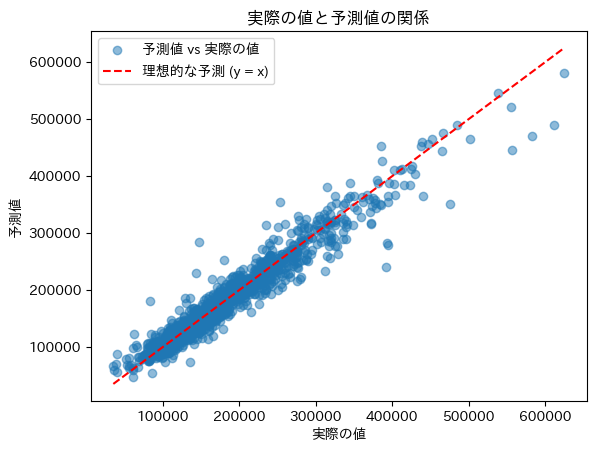

In [60]:
### 結果の可視化(実際の値と予測値)
actual_original = df_train1["SalePrice"]
val_preds_original = np.exp(val_preds)

fig, ax = plt.subplots()
ax.scatter(actual_original, val_preds_original, alpha=0.5, label="予測値 vs 実際の値")

# y = x の直線を引く
min_val = min(actual_original.min(), val_preds_original.min())
max_val = max(actual_original.max(), val_preds_original.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", label="理想的な予測 (y = x)")

ax.set_xlabel("実際の値")
ax.set_ylabel("予測値")
ax.set_title("実際の値と予測値の関係")
ax.legend()
plt.show()

In [61]:
print(actual_original.describe())

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64


In [62]:
# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(test_preds)})
# submission.to_csv("submit/submit_mean.csv", index=False)

#### スタッキング

In [ ]:
### スタッキング → 精度最高

# 予測値をスタッキングの入力データとして作成
stacked_train1 = np.column_stack((lgb_val_preds, lasso_val_preds, ridge_val_preds))
stacked_train1 = pd.DataFrame(stacked_train1)

stacked_test1 = np.column_stack((lgb_test_preds, lasso_test_preds, ridge_test_preds))
stacked_test1 = pd.DataFrame(stacked_test1)


# # 訓練・検証用データを作成
# x_tr, x_val, y_tr, y_val = train_test_split(
#     stacked_train1, y_train1, test_size=0.2, random_state=42
# )

# # メタモデル(XGBoost)
# meta_model1 = xgb.XGBRegressor(**params_xgb2)
# #
# meta_model1.fit(
#     x_tr,
#     y_tr,
#     eval_set=[(x_tr, y_tr), (x_val, y_val)],
#     verbose=100,
# )

# # 最終的な予測
# stacked_val_preds1 = meta_model1.predict(stacked_train1)
# stacked_test_preds1 = meta_model1.predict(stacked_test1)


# score_rmse_1 = rmse(stacked_val_preds1, y_train1)
# print("RMSE:{:.5f}".format(score_rmse_1))
# score_r2_1 = r2_score(stacked_val_preds1, y_train1)
# print("決定係数:{:.5f}".format(score_r2_1))

[0]	validation_0-rmse:0.39187	validation_1-rmse:0.39550


[100]	validation_0-rmse:0.17965	validation_1-rmse:0.19711
[200]	validation_0-rmse:0.11675	validation_1-rmse:0.14028
[300]	validation_0-rmse:0.10307	validation_1-rmse:0.12713
[400]	validation_0-rmse:0.10001	validation_1-rmse:0.12404
[500]	validation_0-rmse:0.09870	validation_1-rmse:0.12315
[600]	validation_0-rmse:0.09779	validation_1-rmse:0.12282
[700]	validation_0-rmse:0.09700	validation_1-rmse:0.12289
[732]	validation_0-rmse:0.09677	validation_1-rmse:0.12298


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:09:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


RMSE:0.10307
決定係数:0.92512


In [64]:
# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(stacked_test_preds1)})
# submission.to_csv("submit/submit_stack1.csv", index=False)

In [69]:
xgb_imp_stack, xgb_scores_stack, xgb_test_preds_stack, xgb_val_preds_stack = (
    xgb_train_cv(
        stacked_train1,
        y_train1,
        stacked_test1,
        params_xgb2,
    )
)

[0]	validation_0-rmse:0.39185	validation_1-rmse:0.39543


[100]	validation_0-rmse:0.17983	validation_1-rmse:0.19742
[200]	validation_0-rmse:0.11671	validation_1-rmse:0.14037
[300]	validation_0-rmse:0.10310	validation_1-rmse:0.12705
[400]	validation_0-rmse:0.09990	validation_1-rmse:0.12407
[500]	validation_0-rmse:0.09861	validation_1-rmse:0.12314
[600]	validation_0-rmse:0.09772	validation_1-rmse:0.12292
[700]	validation_0-rmse:0.09694	validation_1-rmse:0.12307
[723]	validation_0-rmse:0.09675	validation_1-rmse:0.12306
[RSME] tr: 0.09751, val: 0.12287
[0]	validation_0-rmse:0.39074	validation_1-rmse:0.39939


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.18142	validation_1-rmse:0.18122
[200]	validation_0-rmse:0.12015	validation_1-rmse:0.11854
[300]	validation_0-rmse:0.10669	validation_1-rmse:0.10771
[400]	validation_0-rmse:0.10367	validation_1-rmse:0.10705
[500]	validation_0-rmse:0.10239	validation_1-rmse:0.10747
[RSME] tr: 0.10365, val: 0.10704
[0]	validation_0-rmse:0.39250	validation_1-rmse:0.39340
[100]	validation_0-rmse:0.17981	validation_1-rmse:0.18889
[200]	validation_0-rmse:0.11689	validation_1-rmse:0.13273
[300]	validation_0-rmse:0.10317	validation_1-rmse:0.12230
[400]	validation_0-rmse:0.10005	validation_1-rmse:0.12127
[500]	validation_0-rmse:0.09864	validation_1-rmse:0.12131
[531]	validation_0-rmse:0.09832	validation_1-rmse:0.12133
[RSME] tr: 0.09957, val: 0.12119
[0]	validation_0-rmse:0.38662	validation_1-rmse:0.41534
[100]	validation_0-rmse:0.17950	validation_1-rmse:0.20002
[200]	validation_0-rmse:0.11988	validation_1-rmse:0.13307
[300]	validation_0-rmse:0.10711	validation_1-rmse:0.11709
[400]	vali

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:0.10246	validation_1-rmse:0.11052
[600]	validation_0-rmse:0.10140	validation_1-rmse:0.10988
[698]	validation_0-rmse:0.10056	validation_1-rmse:0.11050
[RSME] tr: 0.10140, val: 0.10985
[0]	validation_0-rmse:0.40031	validation_1-rmse:0.35953
[100]	validation_0-rmse:0.18486	validation_1-rmse:0.16238
[200]	validation_0-rmse:0.12244	validation_1-rmse:0.10979
[300]	validation_0-rmse:0.10913	validation_1-rmse:0.10113
[400]	validation_0-rmse:0.10593	validation_1-rmse:0.10092
[441]	validation_0-rmse:0.10529	validation_1-rmse:0.10111
[RSME] tr: 0.10737, val: 0.10062


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [15:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [74]:
print("===== XGBoost =====")
print("\nRMSE")
print(xgb_scores_stack)
print("\nRMSEの平均値")
print(round(np.mean(xgb_scores_stack[:, 2]), 5))

===== XGBoost =====

RMSE
[[0.      0.09751 0.12287]
 [1.      0.10365 0.10704]
 [2.      0.09957 0.12119]
 [3.      0.1014  0.10985]
 [4.      0.10737 0.10062]]

RMSEの平均値
0.11231


In [72]:
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(xgb_test_preds_stack)})
# submission.to_csv("submit/submit_stack1_xgb_stack2.csv", index=False)

In [76]:
print("===== Lasso =====")
lasso_scores_stack, lasso_test_preds_stack, lasso_val_preds_stack = lasso_train_cv(
    stacked_train1, y_train1, stacked_test1
)
print("\nRMSEの平均値")
print(round(np.mean(lasso_scores_stack[:, 2]), 5))

===== Lasso =====
[RSME] tr: 0.10856, val: 0.11858
[RSME] tr: 0.11104, val: 0.10852
[RSME] tr: 0.10829, val: 0.11924
[RSME] tr: 0.11057, val: 0.11072
[RSME] tr: 0.11395, val: 0.09600

RMSEの平均値
0.11061


In [79]:
print("===== Ridge =====")
ridge_scores_stack, ridge_test_preds_stack, ridge_val_preds_stack = ridge_train_cv(
    stacked_train1, y_train1, stacked_test1
)
print("\nRMSEの平均値")
print(round(np.mean(ridge_scores_stack[:, 2]), 5))

===== Ridge =====
[RSME] tr: 0.10912, val: 0.12074
[RSME] tr: 0.11178, val: 0.10874
[RSME] tr: 0.10919, val: 0.11841
[RSME] tr: 0.11108, val: 0.11266
[RSME] tr: 0.11475, val: 0.09567

RMSEの平均値
0.11124


In [81]:
### 最高スコア

# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(xgb_test_preds_stack)})
# submission.to_csv("submit/submit_stack1_xgb.csv", index=False)

In [69]:
# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(lgb_test_preds_stack)})
# submission.to_csv("submit/submit_stack1_lgb.csv", index=False)

#### 結果の可視化

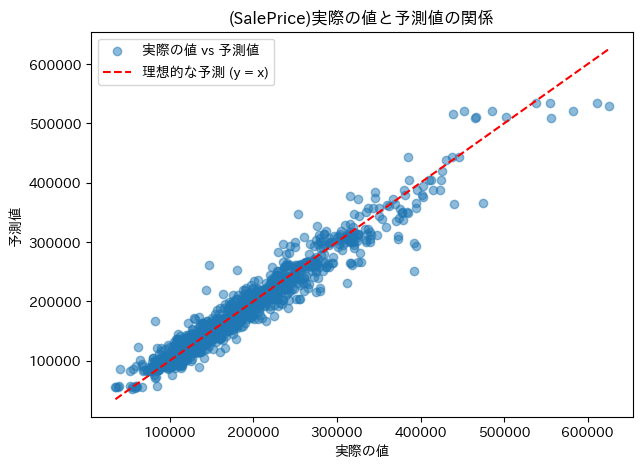

In [82]:
### 結果の可視化(実際の値と予測値)
# 元のスケールに変換
actual_original = df_train1["SalePrice"]
stacked_val_preds_original1 = np.exp(stacked_val_preds1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    actual_original, stacked_val_preds_original1, alpha=0.5, label="実際の値 vs 予測値"
)

# y = x の直線を引く
min_val = min(actual_original.min(), stacked_val_preds_original1.min())
max_val = max(actual_original.max(), stacked_val_preds_original1.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", label="理想的な予測 (y = x)")

ax.set_xlabel("実際の値")
ax.set_ylabel("予測値")
ax.set_title("(SalePrice)実際の値と予測値の関係")
ax.legend()
plt.show()

In [83]:
stacked_val_preds_original_df = pd.Series(stacked_val_preds_original1)
actual_original_df = pd.Series(actual_original)

result_df = pd.concat(
    [stacked_val_preds_original_df, actual_original_df],
    axis=1,
)
result_df.columns = ["pred", "actual"]

# 誤差率を計算
result_df["誤差率"] = abs(result_df["pred"] - result_df["actual"]) / result_df["actual"]
# 絶対値誤差を計算
result_df["絶対値誤差"] = abs(result_df["pred"] - result_df["actual"])


print(
    "絶対値誤差が20万以上：{}".format(len(result_df[result_df["絶対値誤差"] >= 200000]))
)

絶対値誤差が20万以上：59


In [84]:
# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(stacked_test_preds1)})
# submission.to_csv("submit/submit_stack1.csv", index=False)

In [85]:
display(stacked_train1.head())
display(stacked_train1.shape)

display(y_train1.head())
display(y_train1.shape)

,0,1,2
0,12.227114,12.217829,12.216660
1,12.068246,12.106572,12.157310
2,12.299761,12.263080,12.247415
3,11.998771,12.055039,12.040784
4,12.579011,12.560968,12.559764


(1456, 3)

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePriceLog, dtype: float64

(1456,)

#### XGBoost(Oputuna)

In [ ]:
# 説明変数と目的変数
x_train_oputuna = stacked_train1
y_train_oputuna = y_train1


# Optunaの目的関数をラップ
def objective(trial):
    return optimize_lgb(trial, x_train_oputuna, y_train_oputuna, params_base_xgb)


sampler = optuna.samplers.TPESampler(seed=123)
study_xgb = optuna.create_study(sampler=sampler, direction="minimize")
study_xgb.optimize(objective, n_trials=30)

[I 2025-04-10 13:13:13,915] A new study created in memory with name: no-name-e656e4fb-7437-4246-abb0-58882dbf27d3
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37312	validation_1-rmse:0.38728
[100]	validation_0-rmse:0.09070	validation_1-rmse:0.13162


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[186]	validation_0-rmse:0.08517	validation_1-rmse:0.13500
[0]	validation_0-rmse:0.37581	validation_1-rmse:0.37423
[100]	validation_0-rmse:0.09230	validation_1-rmse:0.11944


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[153]	validation_0-rmse:0.08775	validation_1-rmse:0.12343
[0]	validation_0-rmse:0.37516	validation_1-rmse:0.37956
[100]	validation_0-rmse:0.09286	validation_1-rmse:0.11539


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:0.08637	validation_1-rmse:0.11710
[226]	validation_0-rmse:0.08533	validation_1-rmse:0.11713


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36881	validation_1-rmse:0.40223
[100]	validation_0-rmse:0.09213	validation_1-rmse:0.12145
[175]	validation_0-rmse:0.08695	validation_1-rmse:0.12365


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38546	validation_1-rmse:0.33331
[100]	validation_0-rmse:0.09461	validation_1-rmse:0.10911
[153]	validation_0-rmse:0.09101	validation_1-rmse:0.11095


[I 2025-04-10 13:13:32,788] Trial 0 finished with value: 0.11765413152790367 and parameters: {'min_child_weight': 2.471373418487883, 'max_depth': 5, 'subsample': 0.65, 'colsample_bytree': 0.8, 'gamma': 0.005698384608345678}. Best is trial 0 with value: 0.11765413152790367.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37292	validation_1-rmse:0.38697


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.05681	validation_1-rmse:0.13920
[193]	validation_0-rmse:0.04674	validation_1-rmse:0.14135
[0]	validation_0-rmse:0.37571	validation_1-rmse:0.37434


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.05359	validation_1-rmse:0.13276
[149]	validation_0-rmse:0.04631	validation_1-rmse:0.13739


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37514	validation_1-rmse:0.37950
[100]	validation_0-rmse:0.05630	validation_1-rmse:0.12174
[173]	validation_0-rmse:0.04782	validation_1-rmse:0.12387
[0]	validation_0-rmse:0.36866	validation_1-rmse:0.40235


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:13:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.05555	validation_1-rmse:0.12486
[172]	validation_0-rmse:0.04623	validation_1-rmse:0.12778


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38523	validation_1-rmse:0.33331
[100]	validation_0-rmse:0.05643	validation_1-rmse:0.11388
[148]	validation_0-rmse:0.05020	validation_1-rmse:0.11587


[I 2025-04-10 13:14:11,880] Trial 1 finished with value: 0.12347462341718177 and parameters: {'min_child_weight': 0.7017992831138444, 'max_depth': 9, 'subsample': 0.85, 'colsample_bytree': 0.75, 'gamma': 1.3706928443177676e-05}. Best is trial 0 with value: 0.11765413152790367.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37302	validation_1-rmse:0.38705


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08715	validation_1-rmse:0.13217
[182]	validation_0-rmse:0.08267	validation_1-rmse:0.13547
[0]	validation_0-rmse:0.37612	validation_1-rmse:0.37502


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08626	validation_1-rmse:0.12348
[151]	validation_0-rmse:0.08284	validation_1-rmse:0.12689
[0]	validation_0-rmse:0.37520	validation_1-rmse:0.37950


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08936	validation_1-rmse:0.11676
[168]	validation_0-rmse:0.08560	validation_1-rmse:0.11893
[0]	validation_0-rmse:0.36898	validation_1-rmse:0.40273


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08694	validation_1-rmse:0.12709
[179]	validation_0-rmse:0.08220	validation_1-rmse:0.13236
[0]	validation_0-rmse:0.38526	validation_1-rmse:0.33314


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08905	validation_1-rmse:0.11186
[155]	validation_0-rmse:0.08583	validation_1-rmse:0.11348


[I 2025-04-10 13:14:26,091] Trial 2 finished with value: 0.11967107177579843 and parameters: {'min_child_weight': 0.4856865002051285, 'max_depth': 8, 'subsample': 0.75, 'colsample_bytree': 0.6, 'gamma': 1.528811858152725e-05}. Best is trial 0 with value: 0.11765413152790367.


[0]	validation_0-rmse:0.37313	validation_1-rmse:0.38716


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09603	validation_1-rmse:0.12855
[194]	validation_0-rmse:0.09070	validation_1-rmse:0.13088
[0]	validation_0-rmse:0.37583	validation_1-rmse:0.37425


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09729	validation_1-rmse:0.11775
[159]	validation_0-rmse:0.09308	validation_1-rmse:0.12127
[0]	validation_0-rmse:0.37518	validation_1-rmse:0.37959
[100]	validation_0-rmse:0.09803	validation_1-rmse:0.11405


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[181]	validation_0-rmse:0.09342	validation_1-rmse:0.11504
[0]	validation_0-rmse:0.36882	validation_1-rmse:0.40227


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09744	validation_1-rmse:0.12018
[188]	validation_0-rmse:0.09243	validation_1-rmse:0.12266


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38548	validation_1-rmse:0.33331
[100]	validation_0-rmse:0.09961	validation_1-rmse:0.10769
[154]	validation_0-rmse:0.09647	validation_1-rmse:0.10912


[I 2025-04-10 13:14:46,625] Trial 3 finished with value: 0.11656363398197475 and parameters: {'min_child_weight': 2.9922013287804083, 'max_depth': 4, 'subsample': 0.65, 'colsample_bytree': 0.8, 'gamma': 0.00017973005068132485}. Best is trial 3 with value: 0.11656363398197475.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37291	validation_1-rmse:0.38695


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.07616	validation_1-rmse:0.13513
[190]	validation_0-rmse:0.07266	validation_1-rmse:0.13607


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37575	validation_1-rmse:0.37418
[100]	validation_0-rmse:0.07506	validation_1-rmse:0.12548
[149]	validation_0-rmse:0.07312	validation_1-rmse:0.12762


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:14:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37515	validation_1-rmse:0.37951
[100]	validation_0-rmse:0.07614	validation_1-rmse:0.11725
[189]	validation_0-rmse:0.07302	validation_1-rmse:0.11754


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36870	validation_1-rmse:0.40232
[100]	validation_0-rmse:0.07641	validation_1-rmse:0.12243
[176]	validation_0-rmse:0.07311	validation_1-rmse:0.12454


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38526	validation_1-rmse:0.33327
[100]	validation_0-rmse:0.07783	validation_1-rmse:0.11108
[150]	validation_0-rmse:0.07539	validation_1-rmse:0.11218


[I 2025-04-10 13:15:19,486] Trial 4 finished with value: 0.12015016423453836 and parameters: {'min_child_weight': 1.856957298624054, 'max_depth': 8, 'subsample': 0.85, 'colsample_bytree': 0.8, 'gamma': 0.006019314852321063}. Best is trial 3 with value: 0.11656363398197475.


[0]	validation_0-rmse:0.37313	validation_1-rmse:0.38712
[100]	validation_0-rmse:0.08782	validation_1-rmse:0.13072


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[183]	validation_0-rmse:0.08092	validation_1-rmse:0.13333
[0]	validation_0-rmse:0.37580	validation_1-rmse:0.37423
[100]	validation_0-rmse:0.08846	validation_1-rmse:0.12155


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[152]	validation_0-rmse:0.08299	validation_1-rmse:0.12632


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37517	validation_1-rmse:0.37950
[100]	validation_0-rmse:0.08876	validation_1-rmse:0.11515
[200]	validation_0-rmse:0.08045	validation_1-rmse:0.11632
[227]	validation_0-rmse:0.07894	validation_1-rmse:0.11639


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36886	validation_1-rmse:0.40232
[100]	validation_0-rmse:0.08831	validation_1-rmse:0.12174
[187]	validation_0-rmse:0.08063	validation_1-rmse:0.12505
[0]	validation_0-rmse:0.38545	validation_1-rmse:0.33331


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09098	validation_1-rmse:0.10900
[156]	validation_0-rmse:0.08602	validation_1-rmse:0.11122


[I 2025-04-10 13:15:39,499] Trial 5 finished with value: 0.11757077877899946 and parameters: {'min_child_weight': 0.44250463871458173, 'max_depth': 5, 'subsample': 0.65, 'colsample_bytree': 0.7, 'gamma': 0.0011163721427399984}. Best is trial 3 with value: 0.11656363398197475.


[0]	validation_0-rmse:0.37302	validation_1-rmse:0.38711


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.07927	validation_1-rmse:0.13297
[199]	validation_0-rmse:0.06967	validation_1-rmse:0.13723


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37584	validation_1-rmse:0.37440
[100]	validation_0-rmse:0.07939	validation_1-rmse:0.12592
[150]	validation_0-rmse:0.07330	validation_1-rmse:0.12936


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:15:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37531	validation_1-rmse:0.37961
[100]	validation_0-rmse:0.08102	validation_1-rmse:0.11572
[200]	validation_0-rmse:0.07082	validation_1-rmse:0.11702
[204]	validation_0-rmse:0.07053	validation_1-rmse:0.11706


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36890	validation_1-rmse:0.40237
[100]	validation_0-rmse:0.07956	validation_1-rmse:0.12230
[200]	validation_0-rmse:0.06996	validation_1-rmse:0.12518
[201]	validation_0-rmse:0.06984	validation_1-rmse:0.12523
[0]	validation_0-rmse:0.38520	validation_1-rmse:0.33329


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08227	validation_1-rmse:0.10879
[156]	validation_0-rmse:0.07583	validation_1-rmse:0.11082


[I 2025-04-10 13:16:17,800] Trial 6 finished with value: 0.11932202559675036 and parameters: {'min_child_weight': 0.15283044578522445, 'max_depth': 6, 'subsample': 0.75, 'colsample_bytree': 0.75, 'gamma': 2.550599806285011e-05}. Best is trial 3 with value: 0.11656363398197475.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:18] WARNING: /workspa

[0]	validation_0-rmse:0.37299	validation_1-rmse:0.38693
[100]	validation_0-rmse:0.08555	validation_1-rmse:0.13139
[198]	validation_0-rmse:0.07741	validation_1-rmse:0.13369
[0]	validation_0-rmse:0.37593	validation_1-rmse:0.37446


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08707	validation_1-rmse:0.12117
[153]	validation_0-rmse:0.08089	validation_1-rmse:0.12464
[0]	validation_0-rmse:0.37491	validation_1-rmse:0.37929


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08689	validation_1-rmse:0.11669
[169]	validation_0-rmse:0.08057	validation_1-rmse:0.11709


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36869	validation_1-rmse:0.40224
[100]	validation_0-rmse:0.08669	validation_1-rmse:0.12159
[198]	validation_0-rmse:0.07772	validation_1-rmse:0.12317


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38537	validation_1-rmse:0.33326
[100]	validation_0-rmse:0.08912	validation_1-rmse:0.10543
[155]	validation_0-rmse:0.08414	validation_1-rmse:0.10738


[I 2025-04-10 13:16:36,537] Trial 7 finished with value: 0.11806587188344841 and parameters: {'min_child_weight': 0.42123305707366826, 'max_depth': 5, 'subsample': 0.95, 'colsample_bytree': 0.95, 'gamma': 0.00010344116594294054}. Best is trial 3 with value: 0.11656363398197475.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:36] WARNING: /worksp

[0]	validation_0-rmse:0.37336	validation_1-rmse:0.38754
[100]	validation_0-rmse:0.10247	validation_1-rmse:0.12737
[200]	validation_0-rmse:0.10191	validation_1-rmse:0.12736
[241]	validation_0-rmse:0.10180	validation_1-rmse:0.12732


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37628	validation_1-rmse:0.37508
[100]	validation_0-rmse:0.10395	validation_1-rmse:0.11657
[153]	validation_0-rmse:0.10304	validation_1-rmse:0.11707
[0]	validation_0-rmse:0.37539	validation_1-rmse:0.37984
[100]	validation_0-rmse:0.10454	validation_1-rmse:0.11215


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[191]	validation_0-rmse:0.10331	validation_1-rmse:0.11242
[0]	validation_0-rmse:0.36905	validation_1-rmse:0.40306


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10386	validation_1-rmse:0.11858
[200]	validation_0-rmse:0.10295	validation_1-rmse:0.11836
[268]	validation_0-rmse:0.10252	validation_1-rmse:0.11953


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38564	validation_1-rmse:0.33332
[100]	validation_0-rmse:0.10663	validation_1-rmse:0.10699
[167]	validation_0-rmse:0.10611	validation_1-rmse:0.10772


[I 2025-04-10 13:16:56,639] Trial 8 finished with value: 0.11570743998819873 and parameters: {'min_child_weight': 1.769725479197156, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.75, 'gamma': 0.08520660531158526}. Best is trial 8 with value: 0.11570743998819873.


[0]	validation_0-rmse:0.37295	validation_1-rmse:0.38694


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:16:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.07715	validation_1-rmse:0.13463
[200]	validation_0-rmse:0.06787	validation_1-rmse:0.13615
[209]	validation_0-rmse:0.06724	validation_1-rmse:0.13621


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37591	validation_1-rmse:0.37444
[100]	validation_0-rmse:0.07796	validation_1-rmse:0.12538
[150]	validation_0-rmse:0.07138	validation_1-rmse:0.12965
[0]	validation_0-rmse:0.37490	validation_1-rmse:0.37928


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.07864	validation_1-rmse:0.11749
[187]	validation_0-rmse:0.07032	validation_1-rmse:0.11887


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36867	validation_1-rmse:0.40226
[100]	validation_0-rmse:0.07739	validation_1-rmse:0.12326
[199]	validation_0-rmse:0.06813	validation_1-rmse:0.12499
[0]	validation_0-rmse:0.38535	validation_1-rmse:0.33329


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.07984	validation_1-rmse:0.10773
[153]	validation_0-rmse:0.07397	validation_1-rmse:0.10919


[I 2025-04-10 13:17:19,678] Trial 9 finished with value: 0.12018700099391229 and parameters: {'min_child_weight': 0.3168916025578693, 'max_depth': 6, 'subsample': 0.95, 'colsample_bytree': 0.8, 'gamma': 0.0008001219894116966}. Best is trial 8 with value: 0.11570743998819873.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37353	validation_1-rmse:0.38765


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.11192	validation_1-rmse:0.13646
[200]	validation_0-rmse:0.11125	validation_1-rmse:0.13608
[300]	validation_0-rmse:0.11125	validation_1-rmse:0.13607
[400]	validation_0-rmse:0.11126	validation_1-rmse:0.13606
[500]	validation_0-rmse:0.11089	validation_1-rmse:0.13567
[600]	validation_0-rmse:0.11054	validation_1-rmse:0.13552
[700]	validation_0-rmse:0.11054	validation_1-rmse:0.13551
[712]	validation_0-rmse:0.11054	validation_1-rmse:0.13551
[0]	validation_0-rmse:0.37622	validation_1-rmse:0.37481


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.11764	validation_1-rmse:0.11879
[200]	validation_0-rmse:0.11691	validation_1-rmse:0.11793
[300]	validation_0-rmse:0.11631	validation_1-rmse:0.11727
[400]	validation_0-rmse:0.11596	validation_1-rmse:0.11701
[500]	validation_0-rmse:0.11597	validation_1-rmse:0.11704
[600]	validation_0-rmse:0.11576	validation_1-rmse:0.11701
[618]	validation_0-rmse:0.11576	validation_1-rmse:0.11697
[0]	validation_0-rmse:0.37546	validation_1-rmse:0.37985


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.11617	validation_1-rmse:0.12032
[200]	validation_0-rmse:0.11498	validation_1-rmse:0.11920
[286]	validation_0-rmse:0.11499	validation_1-rmse:0.11923
[0]	validation_0-rmse:0.36892	validation_1-rmse:0.40272
[100]	validation_0-rmse:0.11617	validation_1-rmse:0.13405


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:0.11546	validation_1-rmse:0.13295
[300]	validation_0-rmse:0.11510	validation_1-rmse:0.13261
[400]	validation_0-rmse:0.11484	validation_1-rmse:0.13209
[500]	validation_0-rmse:0.11461	validation_1-rmse:0.13133
[553]	validation_0-rmse:0.11461	validation_1-rmse:0.13126


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38561	validation_1-rmse:0.33352
[100]	validation_0-rmse:0.11633	validation_1-rmse:0.11010
[200]	validation_0-rmse:0.11574	validation_1-rmse:0.10979
[300]	validation_0-rmse:0.11551	validation_1-rmse:0.10992
[344]	validation_0-rmse:0.11515	validation_1-rmse:0.10981


[I 2025-04-10 13:17:54,590] Trial 10 finished with value: 0.12251018272455978 and parameters: {'min_child_weight': 9.304853425146671, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.95, 'gamma': 0.8032817764730658}. Best is trial 8 with value: 0.11570743998819873.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37336	validation_1-rmse:0.38754
[100]	validation_0-rmse:0.10067	validation_1-rmse:0.12702


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:0.09691	validation_1-rmse:0.12900
[242]	validation_0-rmse:0.09589	validation_1-rmse:0.12947


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37628	validation_1-rmse:0.37508
[100]	validation_0-rmse:0.10204	validation_1-rmse:0.11387
[186]	validation_0-rmse:0.09828	validation_1-rmse:0.11631


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:17:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37539	validation_1-rmse:0.37984
[100]	validation_0-rmse:0.10249	validation_1-rmse:0.11318
[172]	validation_0-rmse:0.09964	validation_1-rmse:0.11372
[0]	validation_0-rmse:0.36905	validation_1-rmse:0.40306
[100]	validation_0-rmse:0.10240	validation_1-rmse:0.11620


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[192]	validation_0-rmse:0.09849	validation_1-rmse:0.11815
[0]	validation_0-rmse:0.38564	validation_1-rmse:0.33332


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10462	validation_1-rmse:0.10683
[161]	validation_0-rmse:0.10223	validation_1-rmse:0.10771


[I 2025-04-10 13:18:05,561] Trial 11 finished with value: 0.11494133144192904 and parameters: {'min_child_weight': 4.08670533675578, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.85, 'gamma': 2.727032514224038e-08}. Best is trial 11 with value: 0.11494133144192904.


[0]	validation_0-rmse:0.37336	validation_1-rmse:0.38754


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10080	validation_1-rmse:0.12806
[200]	validation_0-rmse:0.09759	validation_1-rmse:0.12890
[246]	validation_0-rmse:0.09656	validation_1-rmse:0.12922
[0]	validation_0-rmse:0.37628	validation_1-rmse:0.37508
[100]	validation_0-rmse:0.10378	validation_1-rmse:0.11151
[187]	validation_0-rmse:0.10051	validation_1-rmse:0.11281


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37539	validation_1-rmse:0.37984
[100]	validation_0-rmse:0.10311	validation_1-rmse:0.11325
[172]	validation_0-rmse:0.10046	validation_1-rmse:0.11437


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36905	validation_1-rmse:0.40306
[100]	validation_0-rmse:0.10341	validation_1-rmse:0.11517
[198]	validation_0-rmse:0.10000	validation_1-rmse:0.11652
[0]	validation_0-rmse:0.38564	validation_1-rmse:0.33332
[100]	validation_0-rmse:0.10497	validation_1-rmse:0.10724


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[170]	validation_0-rmse:0.10246	validation_1-rmse:0.10836


[I 2025-04-10 13:18:16,834] Trial 12 finished with value: 0.11451333180298535 and parameters: {'min_child_weight': 6.524361435440222, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'gamma': 1.1797476912384551e-08}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:17] WARNING: /workspac

[0]	validation_0-rmse:0.37322	validation_1-rmse:0.38744
[100]	validation_0-rmse:0.10058	validation_1-rmse:0.12737
[200]	validation_0-rmse:0.09761	validation_1-rmse:0.12855
[202]	validation_0-rmse:0.09759	validation_1-rmse:0.12866
[0]	validation_0-rmse:0.37630	validation_1-rmse:0.37507
[100]	validation_0-rmse:0.10409	validation_1-rmse:0.11127


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[177]	validation_0-rmse:0.10111	validation_1-rmse:0.11266


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37547	validation_1-rmse:0.37995
[100]	validation_0-rmse:0.10315	validation_1-rmse:0.11337
[175]	validation_0-rmse:0.10073	validation_1-rmse:0.11407
[0]	validation_0-rmse:0.36902	validation_1-rmse:0.40299


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10377	validation_1-rmse:0.11624
[199]	validation_0-rmse:0.10048	validation_1-rmse:0.11802


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38553	validation_1-rmse:0.33337
[100]	validation_0-rmse:0.10513	validation_1-rmse:0.10782
[171]	validation_0-rmse:0.10249	validation_1-rmse:0.10867


[I 2025-04-10 13:18:34,954] Trial 13 finished with value: 0.11466617132593915 and parameters: {'min_child_weight': 8.504907433712528, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 1.344678420407299e-08}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37299	validation_1-rmse:0.38705


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09805	validation_1-rmse:0.12928
[200]	validation_0-rmse:0.09446	validation_1-rmse:0.13067
[203]	validation_0-rmse:0.09440	validation_1-rmse:0.13090


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37604	validation_1-rmse:0.37475
[100]	validation_0-rmse:0.10240	validation_1-rmse:0.11128
[176]	validation_0-rmse:0.09886	validation_1-rmse:0.11314


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37529	validation_1-rmse:0.37980
[100]	validation_0-rmse:0.10103	validation_1-rmse:0.11392
[176]	validation_0-rmse:0.09797	validation_1-rmse:0.11547


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36876	validation_1-rmse:0.40260
[100]	validation_0-rmse:0.10211	validation_1-rmse:0.11776
[200]	validation_0-rmse:0.09814	validation_1-rmse:0.11845
[208]	validation_0-rmse:0.09783	validation_1-rmse:0.11856
[0]	validation_0-rmse:0.38526	validation_1-rmse:0.33318


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10261	validation_1-rmse:0.10814
[152]	validation_0-rmse:0.10018	validation_1-rmse:0.10838


[I 2025-04-10 13:18:59,021] Trial 14 finished with value: 0.11547974590734249 and parameters: {'min_child_weight': 9.290142894516848, 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 1.0700919266316066e-08}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:18:59] WARNING: /workspac

[0]	validation_0-rmse:0.37300	validation_1-rmse:0.38695
[100]	validation_0-rmse:0.09683	validation_1-rmse:0.12841
[200]	validation_0-rmse:0.09226	validation_1-rmse:0.13001
[210]	validation_0-rmse:0.09197	validation_1-rmse:0.13026
[0]	validation_0-rmse:0.37582	validation_1-rmse:0.37420


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09965	validation_1-rmse:0.11326
[158]	validation_0-rmse:0.09632	validation_1-rmse:0.11477
[0]	validation_0-rmse:0.37518	validation_1-rmse:0.37953


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09948	validation_1-rmse:0.11506
[180]	validation_0-rmse:0.09603	validation_1-rmse:0.11598
[0]	validation_0-rmse:0.36876	validation_1-rmse:0.40228


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09958	validation_1-rmse:0.11660
[199]	validation_0-rmse:0.09522	validation_1-rmse:0.11852
[0]	validation_0-rmse:0.38532	validation_1-rmse:0.33326


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10126	validation_1-rmse:0.10762
[155]	validation_0-rmse:0.09817	validation_1-rmse:0.10775


[I 2025-04-10 13:19:17,422] Trial 15 finished with value: 0.11536160392498704 and parameters: {'min_child_weight': 5.290267585027928, 'max_depth': 4, 'subsample': 0.85, 'colsample_bytree': 0.9, 'gamma': 2.6041950974324554e-07}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:17] WARNING: /workspa

[0]	validation_0-rmse:0.37322	validation_1-rmse:0.38744
[100]	validation_0-rmse:0.09934	validation_1-rmse:0.12666
[200]	validation_0-rmse:0.09502	validation_1-rmse:0.12731
[215]	validation_0-rmse:0.09457	validation_1-rmse:0.12767
[0]	validation_0-rmse:0.37630	validation_1-rmse:0.37507


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10061	validation_1-rmse:0.11741
[155]	validation_0-rmse:0.09712	validation_1-rmse:0.12014


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37547	validation_1-rmse:0.37995
[100]	validation_0-rmse:0.10141	validation_1-rmse:0.11203
[184]	validation_0-rmse:0.09677	validation_1-rmse:0.11266


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36902	validation_1-rmse:0.40299
[100]	validation_0-rmse:0.10141	validation_1-rmse:0.11855
[200]	validation_0-rmse:0.09661	validation_1-rmse:0.12072
[0]	validation_0-rmse:0.38553	validation_1-rmse:0.33337


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10350	validation_1-rmse:0.10780
[156]	validation_0-rmse:0.10051	validation_1-rmse:0.10815


[I 2025-04-10 13:19:36,964] Trial 16 finished with value: 0.11550938408545111 and parameters: {'min_child_weight': 1.1194091605077652, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 8.099698489281743e-07}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:37] WARNING: /workspac

[0]	validation_0-rmse:0.37301	validation_1-rmse:0.38702
[100]	validation_0-rmse:0.08365	validation_1-rmse:0.13400
[200]	validation_0-rmse:0.07797	validation_1-rmse:0.13662
[0]	validation_0-rmse:0.37581	validation_1-rmse:0.37437


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08590	validation_1-rmse:0.11783
[157]	validation_0-rmse:0.08144	validation_1-rmse:0.12038
[0]	validation_0-rmse:0.37508	validation_1-rmse:0.37939


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08632	validation_1-rmse:0.11849
[180]	validation_0-rmse:0.08134	validation_1-rmse:0.11947
[0]	validation_0-rmse:0.36877	validation_1-rmse:0.40232


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08626	validation_1-rmse:0.12013
[188]	validation_0-rmse:0.08067	validation_1-rmse:0.12184


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38532	validation_1-rmse:0.33324
[100]	validation_0-rmse:0.08767	validation_1-rmse:0.11095
[151]	validation_0-rmse:0.08409	validation_1-rmse:0.11231


[I 2025-04-10 13:19:58,934] Trial 17 finished with value: 0.11904340565527054 and parameters: {'min_child_weight': 5.799168771931534, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 0.85, 'gamma': 1.8720413456828075e-07}. Best is trial 12 with value: 0.11451333180298535.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37314	validation_1-rmse:0.38694


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:19:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10023	validation_1-rmse:0.12791
[198]	validation_0-rmse:0.09702	validation_1-rmse:0.12907


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37594	validation_1-rmse:0.37473
[100]	validation_0-rmse:0.10347	validation_1-rmse:0.11024
[165]	validation_0-rmse:0.10096	validation_1-rmse:0.11129


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37527	validation_1-rmse:0.37959
[100]	validation_0-rmse:0.10215	validation_1-rmse:0.11330
[182]	validation_0-rmse:0.09927	validation_1-rmse:0.11492
[0]	validation_0-rmse:0.36894	validation_1-rmse:0.40281


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10268	validation_1-rmse:0.11722
[198]	validation_0-rmse:0.09905	validation_1-rmse:0.11848
[0]	validation_0-rmse:0.38545	validation_1-rmse:0.33324


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10411	validation_1-rmse:0.10670
[157]	validation_0-rmse:0.10207	validation_1-rmse:0.10703


[I 2025-04-10 13:20:24,522] Trial 18 finished with value: 0.11438215124556683 and parameters: {'min_child_weight': 6.261089330680701, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.65, 'gamma': 1.586379977513753e-06}. Best is trial 18 with value: 0.11438215124556683.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:24] WARNING: /workspac

[0]	validation_0-rmse:0.37314	validation_1-rmse:0.38694
[100]	validation_0-rmse:0.09911	validation_1-rmse:0.12604
[200]	validation_0-rmse:0.09518	validation_1-rmse:0.12728
[207]	validation_0-rmse:0.09497	validation_1-rmse:0.12749
[0]	validation_0-rmse:0.37594	validation_1-rmse:0.37473


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09956	validation_1-rmse:0.11776
[153]	validation_0-rmse:0.09690	validation_1-rmse:0.12085
[0]	validation_0-rmse:0.37527	validation_1-rmse:0.37959


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10075	validation_1-rmse:0.11272
[187]	validation_0-rmse:0.09703	validation_1-rmse:0.11433
[0]	validation_0-rmse:0.36894	validation_1-rmse:0.40281


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09958	validation_1-rmse:0.12095
[198]	validation_0-rmse:0.09517	validation_1-rmse:0.12502
[0]	validation_0-rmse:0.38545	validation_1-rmse:0.33324


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10231	validation_1-rmse:0.10709
[155]	validation_0-rmse:0.09967	validation_1-rmse:0.10625


[I 2025-04-10 13:20:45,500] Trial 19 finished with value: 0.11558668966572254 and parameters: {'min_child_weight': 1.3456721486521732, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.6, 'gamma': 1.7176138401951035e-06}. Best is trial 18 with value: 0.11438215124556683.


[0]	validation_0-rmse:0.37305	validation_1-rmse:0.38702


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09544	validation_1-rmse:0.12809
[200]	validation_0-rmse:0.09146	validation_1-rmse:0.12993
[211]	validation_0-rmse:0.09110	validation_1-rmse:0.12984
[0]	validation_0-rmse:0.37614	validation_1-rmse:0.37502


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09662	validation_1-rmse:0.11828
[152]	validation_0-rmse:0.09364	validation_1-rmse:0.11991
[0]	validation_0-rmse:0.37519	validation_1-rmse:0.37953


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:20:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09767	validation_1-rmse:0.11351
[200]	validation_0-rmse:0.09369	validation_1-rmse:0.11478
[226]	validation_0-rmse:0.09293	validation_1-rmse:0.11524


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36900	validation_1-rmse:0.40271
[100]	validation_0-rmse:0.09644	validation_1-rmse:0.12241
[200]	validation_0-rmse:0.09175	validation_1-rmse:0.12577
[205]	validation_0-rmse:0.09159	validation_1-rmse:0.12613
[0]	validation_0-rmse:0.38525	validation_1-rmse:0.33307


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09868	validation_1-rmse:0.10720
[154]	validation_0-rmse:0.09620	validation_1-rmse:0.10735


[I 2025-04-10 13:21:11,119] Trial 20 finished with value: 0.11651353943455496 and parameters: {'min_child_weight': 3.952842476824547, 'max_depth': 5, 'subsample': 0.75, 'colsample_bytree': 0.65, 'gamma': 7.916424697028306e-08}. Best is trial 18 with value: 0.11438215124556683.


[0]	validation_0-rmse:0.37355	validation_1-rmse:0.38767
[100]	validation_0-rmse:0.10236	validation_1-rmse:0.12780


/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[197]	validation_0-rmse:0.09976	validation_1-rmse:0.12783
[0]	validation_0-rmse:0.37631	validation_1-rmse:0.37515


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10661	validation_1-rmse:0.11035
[169]	validation_0-rmse:0.10394	validation_1-rmse:0.11152
[0]	validation_0-rmse:0.37546	validation_1-rmse:0.37986


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10495	validation_1-rmse:0.11188
[200]	validation_0-rmse:0.10174	validation_1-rmse:0.11381
[202]	validation_0-rmse:0.10169	validation_1-rmse:0.11381


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36902	validation_1-rmse:0.40284
[100]	validation_0-rmse:0.10554	validation_1-rmse:0.11761
[200]	validation_0-rmse:0.10269	validation_1-rmse:0.11683
[250]	validation_0-rmse:0.10155	validation_1-rmse:0.11780


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38581	validation_1-rmse:0.33361
[100]	validation_0-rmse:0.10663	validation_1-rmse:0.10619
[171]	validation_0-rmse:0.10422	validation_1-rmse:0.10649


[I 2025-04-10 13:21:16,135] Trial 21 finished with value: 0.11405715272372403 and parameters: {'min_child_weight': 6.553074575810416, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.65, 'gamma': 2.355739475587996e-06}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37327	validation_1-rmse:0.38730


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10014	validation_1-rmse:0.12845
[196]	validation_0-rmse:0.09693	validation_1-rmse:0.12886
[0]	validation_0-rmse:0.37593	validation_1-rmse:0.37465


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10387	validation_1-rmse:0.11054
[169]	validation_0-rmse:0.10095	validation_1-rmse:0.11161


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37524	validation_1-rmse:0.37968
[100]	validation_0-rmse:0.10254	validation_1-rmse:0.11380
[168]	validation_0-rmse:0.09997	validation_1-rmse:0.11525
[0]	validation_0-rmse:0.36890	validation_1-rmse:0.40259
[100]	validation_0-rmse:0.10279	validation_1-rmse:0.11863
[200]	validation_0-rmse:0.09898	validation_1-rmse:0.11939


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[261]	validation_0-rmse:0.09735	validation_1-rmse:0.12123
[0]	validation_0-rmse:0.38544	validation_1-rmse:0.33320


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10440	validation_1-rmse:0.10610
[154]	validation_0-rmse:0.10223	validation_1-rmse:0.10608


[I 2025-04-10 13:21:30,354] Trial 22 finished with value: 0.11467609425343028 and parameters: {'min_child_weight': 5.9935170334168335, 'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 0.65, 'gamma': 2.986524940462042e-06}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:30] WARNING: /workspa

[0]	validation_0-rmse:0.37355	validation_1-rmse:0.38767
[100]	validation_0-rmse:0.10194	validation_1-rmse:0.12679
[200]	validation_0-rmse:0.09909	validation_1-rmse:0.12708
[246]	validation_0-rmse:0.09812	validation_1-rmse:0.12723
[0]	validation_0-rmse:0.37631	validation_1-rmse:0.37515
[100]	validation_0-rmse:0.10401	validation_1-rmse:0.11421
[159]	validation_0-rmse:0.10128	validation_1-rmse:0.11666


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37546	validation_1-rmse:0.37986
[100]	validation_0-rmse:0.10390	validation_1-rmse:0.11197
[183]	validation_0-rmse:0.10122	validation_1-rmse:0.11265
[0]	validation_0-rmse:0.36902	validation_1-rmse:0.40284
[100]	validation_0-rmse:0.10369	validation_1-rmse:0.11979


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[199]	validation_0-rmse:0.10010	validation_1-rmse:0.12061


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38581	validation_1-rmse:0.33361
[100]	validation_0-rmse:0.10601	validation_1-rmse:0.10604
[171]	validation_0-rmse:0.10351	validation_1-rmse:0.10540


[I 2025-04-10 13:21:37,777] Trial 23 finished with value: 0.1149952594131737 and parameters: {'min_child_weight': 3.099492108816813, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.65, 'gamma': 3.881472799031959e-06}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:38] WARNING: /workspace

[0]	validation_0-rmse:0.37313	validation_1-rmse:0.38716
[100]	validation_0-rmse:0.09793	validation_1-rmse:0.12885
[200]	validation_0-rmse:0.09373	validation_1-rmse:0.13060
[208]	validation_0-rmse:0.09355	validation_1-rmse:0.13058
[0]	validation_0-rmse:0.37588	validation_1-rmse:0.37445


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10156	validation_1-rmse:0.11225
[166]	validation_0-rmse:0.09799	validation_1-rmse:0.11347
[0]	validation_0-rmse:0.37518	validation_1-rmse:0.37959


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10017	validation_1-rmse:0.11441
[171]	validation_0-rmse:0.09720	validation_1-rmse:0.11557
[0]	validation_0-rmse:0.36882	validation_1-rmse:0.40227


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10059	validation_1-rmse:0.11728
[195]	validation_0-rmse:0.09674	validation_1-rmse:0.11812
[0]	validation_0-rmse:0.38548	validation_1-rmse:0.33331


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:21:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10207	validation_1-rmse:0.10694
[153]	validation_0-rmse:0.09974	validation_1-rmse:0.10826


[I 2025-04-10 13:22:06,985] Trial 24 finished with value: 0.11529245210504457 and parameters: {'min_child_weight': 6.75126123673574, 'max_depth': 4, 'subsample': 0.65, 'colsample_bytree': 0.7, 'gamma': 4.842042855297292e-07}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:07] WARNING: /workspace

[0]	validation_0-rmse:0.37336	validation_1-rmse:0.38754
[100]	validation_0-rmse:0.10067	validation_1-rmse:0.12702
[200]	validation_0-rmse:0.09691	validation_1-rmse:0.12900
[243]	validation_0-rmse:0.09590	validation_1-rmse:0.12936


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37628	validation_1-rmse:0.37508
[100]	validation_0-rmse:0.10204	validation_1-rmse:0.11387
[186]	validation_0-rmse:0.09828	validation_1-rmse:0.11631
[0]	validation_0-rmse:0.37539	validation_1-rmse:0.37984


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10249	validation_1-rmse:0.11318
[173]	validation_0-rmse:0.09962	validation_1-rmse:0.11376


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36905	validation_1-rmse:0.40306
[100]	validation_0-rmse:0.10240	validation_1-rmse:0.11620
[191]	validation_0-rmse:0.09852	validation_1-rmse:0.11815
[0]	validation_0-rmse:0.38564	validation_1-rmse:0.33332


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10462	validation_1-rmse:0.10683
[160]	validation_0-rmse:0.10223	validation_1-rmse:0.10758


[I 2025-04-10 13:22:29,533] Trial 25 finished with value: 0.11494133144192904 and parameters: {'min_child_weight': 4.1780654109545825, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 8.537503040424896e-08}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37313	validation_1-rmse:0.38698


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09896	validation_1-rmse:0.12658
[200]	validation_0-rmse:0.09498	validation_1-rmse:0.12843
[211]	validation_0-rmse:0.09456	validation_1-rmse:0.12862


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37593	validation_1-rmse:0.37471
[100]	validation_0-rmse:0.10036	validation_1-rmse:0.11703
[152]	validation_0-rmse:0.09756	validation_1-rmse:0.11988
[0]	validation_0-rmse:0.37521	validation_1-rmse:0.37959


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10099	validation_1-rmse:0.11273
[187]	validation_0-rmse:0.09731	validation_1-rmse:0.11399


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.36889	validation_1-rmse:0.40260
[100]	validation_0-rmse:0.09979	validation_1-rmse:0.12094
[199]	validation_0-rmse:0.09563	validation_1-rmse:0.12364
[0]	validation_0-rmse:0.38552	validation_1-rmse:0.33324


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10281	validation_1-rmse:0.10646
[155]	validation_0-rmse:0.10032	validation_1-rmse:0.10590


[I 2025-04-10 13:22:43,985] Trial 26 finished with value: 0.11559775521148466 and parameters: {'min_child_weight': 2.2668880060147862, 'max_depth': 4, 'subsample': 0.65, 'colsample_bytree': 0.6, 'gamma': 6.319795161774963e-06}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:44] WARNING: /workspa

[0]	validation_0-rmse:0.37326	validation_1-rmse:0.38724
[100]	validation_0-rmse:0.09794	validation_1-rmse:0.12968
[187]	validation_0-rmse:0.09471	validation_1-rmse:0.13075
[0]	validation_0-rmse:0.37608	validation_1-rmse:0.37488
[100]	validation_0-rmse:0.10187	validation_1-rmse:0.11164


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[162]	validation_0-rmse:0.09872	validation_1-rmse:0.11307
[0]	validation_0-rmse:0.37523	validation_1-rmse:0.37965


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10051	validation_1-rmse:0.11375
[183]	validation_0-rmse:0.09706	validation_1-rmse:0.11600
[0]	validation_0-rmse:0.36890	validation_1-rmse:0.40258


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10056	validation_1-rmse:0.11854
[200]	validation_0-rmse:0.09663	validation_1-rmse:0.11917
[250]	validation_0-rmse:0.09514	validation_1-rmse:0.12051
[0]	validation_0-rmse:0.38541	validation_1-rmse:0.33319


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:22:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10202	validation_1-rmse:0.10623
[157]	validation_0-rmse:0.09965	validation_1-rmse:0.10707


[I 2025-04-10 13:23:00,063] Trial 27 finished with value: 0.11502124982135213 and parameters: {'min_child_weight': 6.889269398081049, 'max_depth': 5, 'subsample': 0.6, 'colsample_bytree': 0.65, 'gamma': 4.239222687493718e-08}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37336	validation_1-rmse:0.38754


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09950	validation_1-rmse:0.12656
[200]	validation_0-rmse:0.09439	validation_1-rmse:0.12857
[224]	validation_0-rmse:0.09334	validation_1-rmse:0.12905


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37628	validation_1-rmse:0.37508
[100]	validation_0-rmse:0.10032	validation_1-rmse:0.11762
[152]	validation_0-rmse:0.09693	validation_1-rmse:0.12071
[0]	validation_0-rmse:0.37539	validation_1-rmse:0.37984


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10065	validation_1-rmse:0.11195
[190]	validation_0-rmse:0.09558	validation_1-rmse:0.11293
[0]	validation_0-rmse:0.36905	validation_1-rmse:0.40306


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10093	validation_1-rmse:0.11866
[200]	validation_0-rmse:0.09595	validation_1-rmse:0.12125
[203]	validation_0-rmse:0.09577	validation_1-rmse:0.12116


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38564	validation_1-rmse:0.33332
[100]	validation_0-rmse:0.10295	validation_1-rmse:0.10747
[157]	validation_0-rmse:0.09955	validation_1-rmse:0.10805


[I 2025-04-10 13:23:31,891] Trial 28 finished with value: 0.11542281534370843 and parameters: {'min_child_weight': 0.11909755957026395, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 1.1811687888700895e-06}. Best is trial 21 with value: 0.11405715272372403.
/tmp/ipykernel_449/755024085.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
/tmp/ipykernel_449/755024085.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),


[0]	validation_0-rmse:0.37303	validation_1-rmse:0.38711


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.08945	validation_1-rmse:0.13075
[200]	validation_0-rmse:0.08305	validation_1-rmse:0.13432
[0]	validation_0-rmse:0.37587	validation_1-rmse:0.37424


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09092	validation_1-rmse:0.11905
[156]	validation_0-rmse:0.08594	validation_1-rmse:0.12331
[0]	validation_0-rmse:0.37533	validation_1-rmse:0.37961


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09164	validation_1-rmse:0.11445
[200]	validation_0-rmse:0.08480	validation_1-rmse:0.11578
[202]	validation_0-rmse:0.08470	validation_1-rmse:0.11600
[0]	validation_0-rmse:0.36893	validation_1-rmse:0.40236


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09061	validation_1-rmse:0.12117
[177]	validation_0-rmse:0.08510	validation_1-rmse:0.12341
[0]	validation_0-rmse:0.38522	validation_1-rmse:0.33315


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:23:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.09367	validation_1-rmse:0.10876
[150]	validation_0-rmse:0.08998	validation_1-rmse:0.11060


[I 2025-04-10 13:23:54,302] Trial 29 finished with value: 0.11755695540276842 and parameters: {'min_child_weight': 2.569986121399213, 'max_depth': 5, 'subsample': 0.75, 'colsample_bytree': 0.85, 'gamma': 5.005490032724267e-05}. Best is trial 21 with value: 0.11405715272372403.


In [101]:
# 結果
trial_xgb = study_xgb.best_trial
print("RMSE(best)：{:.4f}".format(trial_xgb.value))
print("ベストパラメータ：{}".format(trial_xgb.params))

RMSE(best)：0.1141
ベストパラメータ：{'min_child_weight': 6.553074575810416, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.65, 'gamma': 2.355739475587996e-06}


In [102]:
params_best_xgb = trial_xgb.params
params_best_xgb.update(params_base_xgb)  # ベースパラメータを追加
display(params_best_xgb)

{'min_child_weight': 6.553074575810416,
 'max_depth': 3,
 'subsample': 0.6,
 'colsample_bytree': 0.65,
 'gamma': 2.355739475587996e-06,
 'objective': 'reg:squarederror',
 'metric': 'rmse',
 'eta': 0.05,
 'alpha': 0.0,
 'lambda': 1.0,
 'n_estimators': 10000,
 'importance_type': 'total_gain',
 'early_stopping_rounds': 100,
 'random_state': 123}

In [103]:
xgb_imp_oputuna, xgb_scores_oputuna, xgb_test_preds_oputuna, xgb_val_preds_oputuna = (
    xgb_train_cv(
        stacked_train1, y_train1, id_train1, stacked_test1, params_best_xgb, n_splits=5
    )
)

/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:24:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37355	validation_1-rmse:0.38767
[100]	validation_0-rmse:0.10236	validation_1-rmse:0.12780
[197]	validation_0-rmse:0.09976	validation_1-rmse:0.12783
[RSME] tr: 0.10244, val: 0.12747
[0]	validation_0-rmse:0.37631	validation_1-rmse:0.37515
[100]	validation_0-rmse:0.10661	validation_1-rmse:0.11035


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:25:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[168]	validation_0-rmse:0.10400	validation_1-rmse:0.11149
[RSME] tr: 0.10910, val: 0.10979


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:25:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.37546	validation_1-rmse:0.37986
[100]	validation_0-rmse:0.10495	validation_1-rmse:0.11188
[200]	validation_0-rmse:0.10174	validation_1-rmse:0.11381
[201]	validation_0-rmse:0.10170	validation_1-rmse:0.11379
[RSME] tr: 0.10490, val: 0.11181
[0]	validation_0-rmse:0.36902	validation_1-rmse:0.40284


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:25:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:0.10554	validation_1-rmse:0.11761
[200]	validation_0-rmse:0.10269	validation_1-rmse:0.11683
[250]	validation_0-rmse:0.10155	validation_1-rmse:0.11780
[RSME] tr: 0.10399, val: 0.11608


/usr/local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [13:25:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "metric" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.38581	validation_1-rmse:0.33361
[100]	validation_0-rmse:0.10663	validation_1-rmse:0.10619
[171]	validation_0-rmse:0.10422	validation_1-rmse:0.10649
[RSME] tr: 0.10832, val: 0.10513


In [104]:
print("===== XGBoost =====")
print("\nRMSE")
print(xgb_scores_oputuna)
print("\nRMSEの平均値")
print(round(np.mean(xgb_scores_oputuna[:, 2]), 5))
# print("\n特徴量重要度")
# display(xgb_imp.sort_values("imp_mean", ascending=False))

===== XGBoost =====

RMSE
[[0.      0.10244 0.12747]
 [1.      0.1091  0.10979]
 [2.      0.1049  0.11181]
 [3.      0.10399 0.11608]
 [4.      0.10832 0.10513]]

RMSEの平均値
0.11406


In [105]:
# 提出用ファイルの作成
submission = pd.DataFrame({"Id": id_test, "SalePrice": np.exp(xgb_test_preds_oputuna)})
submission.to_csv("submit/submit_stack1_xgb_oputuna.csv", index=False)

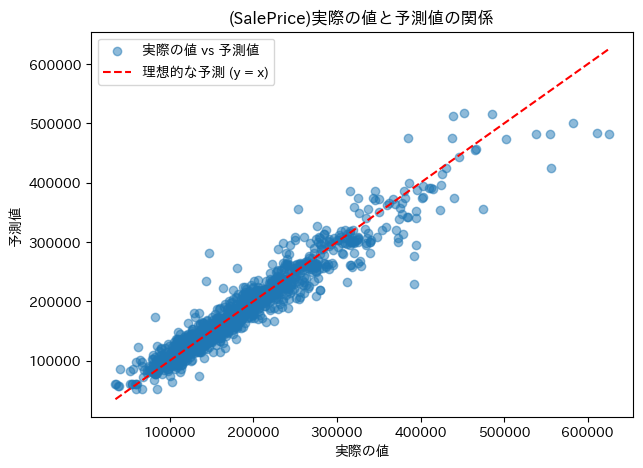

In [59]:
### 結果の可視化(実際の値と予測値)
# 元のスケールに変換
actual_original = np.exp(y_train1)
stacked_val_preds_original2 = np.exp(xgb_val_preds_stack)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(
    actual_original, stacked_val_preds_original2, alpha=0.5, label="実際の値 vs 予測値"
)

# y = x の直線を引く
min_val = min(actual_original.min(), stacked_val_preds_original2.min())
max_val = max(actual_original.max(), stacked_val_preds_original2.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", label="理想的な予測 (y = x)")

ax.set_xlabel("実際の値")
ax.set_ylabel("予測値")
ax.set_title("(SalePrice)実際の値と予測値の関係")
ax.legend()
plt.show()

In [61]:
stacked_val_preds_original_df2 = pd.Series(stacked_val_preds_original2)

result_df = pd.concat(
    [stacked_val_preds_original_df2, actual_original],
    axis=1,
)
result_df.columns = ["pred", "actual"]

# abs は絶対値（absolute value） を求める関数
# 誤差率を計算
result_df["誤差率"] = abs(result_df["pred"] - result_df["actual"]) / result_df["actual"]
# 絶対値誤差を計算
result_df["絶対値誤差"] = abs(result_df["pred"] - result_df["actual"])

print(
    "絶対値誤差が20万以上：{}".format(len(result_df[result_df["絶対値誤差"] >= 200000]))
)

# result_df[result_df["絶対値誤差"] >= 200000]

絶対値誤差が20万以上：56
